 # Getting Started: MPC

Getting familiar with core funcitonalities of do-mpc

In [ ]:
import numpy as np
import do_mpc
from casadi import *

The system to be implemented is a triple mass spring system:

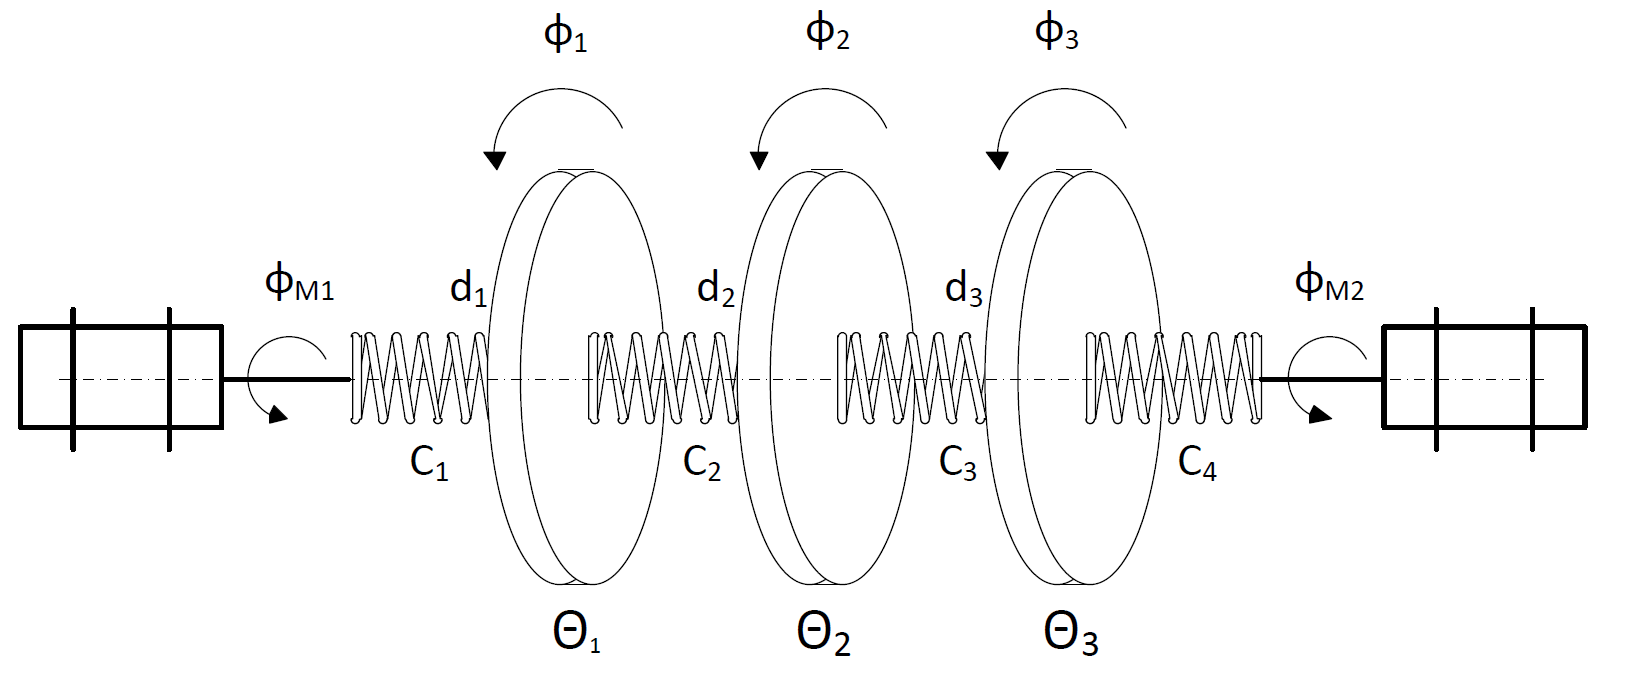

The systems contains discs, springs and a stepper motor. Stepper motor angles are inputs to system.

A second degree ODE explains how the system works.

We have DAE/ODE. We denote x as states, u as inputs, z as algebraic states and p as parameters.

# We start by creating the model

In [10]:
model_type = 'continuous' # can be either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

# Defining model variables
phi_1 = model.set_variable(var_type='_x', var_name='phi_1', shape=(1,1))
phi_2 = model.set_variable(var_type='_x', var_name='phi_2', shape=(1,1))
phi_3 = model.set_variable(var_type='_x', var_name='phi_3', shape=(1,1))
# Variables can also be vectors:
dphi = model.set_variable(var_type='_x', var_name='dphi', shape=(3,1))
# Two states for the desired (set) motor position:
phi_m_1_set = model.set_variable(var_type='_u', var_name='phi_m_1_set')
phi_m_2_set = model.set_variable(var_type='_u', var_name='phi_m_2_set')
# Two additional states for the true motor position:
phi_1_m = model.set_variable(var_type='_x', var_name='phi_1_m', shape=(1,1))
phi_2_m = model.set_variable(var_type='_x', var_name='phi_2_m', shape=(1,1))

# Different ways of obtaining model variables
model.x
model.x['phi_1'] # Accessing with indices
model.x.keys() # Accessing with .keys()
model.x.labels() # Accessing with .labels()

['[phi_1,0]',
 '[phi_2,0]',
 '[phi_3,0]',
 '[dphi,0]',
 '[dphi,1]',
 '[dphi,2]',
 '[phi_1_m,0]',
 '[phi_2_m,0]']

In [ ]:
# Defining model parameters
Theta_1 = model.set_variable('parameter', 'Theta_1')
Theta_2 = model.set_variable('parameter', 'Theta_2')
Theta_3 = model.set_variable('parameter', 'Theta_3')

c = np.array([2.697,  2.66,  3.05, 2.86])*1e-3
d = np.array([6.78,  8.01,  8.82])*1e-5

# Defining rhs. of model
model.set_rhs('phi_1', dphi[0])
model.set_rhs('phi_2', dphi[1])
model.set_rhs('phi_3', dphi[2])

# Concatenating symbolic expressions with CasADi
dphi_next = vertcat(
    -c[0]/Theta_1*(phi_1-phi_1_m)-c[1]/Theta_1*(phi_1-phi_2)-d[0]/Theta_1*dphi[0],
    -c[1]/Theta_2*(phi_2-phi_1)-c[2]/Theta_2*(phi_2-phi_3)-d[1]/Theta_2*dphi[1],
    -c[2]/Theta_3*(phi_3-phi_2)-c[3]/Theta_3*(phi_3-phi_2_m)-d[2]/Theta_3*dphi[2],
)

model.set_rhs('dphi', dphi_next)
tau = 1e-2
model.set_rhs('phi_1_m', 1/tau*(phi_m_1_set - phi_1_m))
model.set_rhs('phi_2_m', 1/tau*(phi_m_2_set - phi_2_m))
model.setup() # After calling model.setup() we cannot define further variables

# Now we configure the MPC controller

In [ ]:
# Creating the object
mpc = do_mpc.controller.MPC(model)

# Parametrize the optimizer. Important parameters are 'n_horizon' and 't_step'.
setup_mpc = {
    'n_horizon': 20,
    't_step': 0.1,
    'n_robust': 1,
    'store_full_solution': True,
}

mpc.set_param(**setup_mpc)

In [ ]:
# Defining an objective function for the omptimization prblem
